In [1]:
%load_ext autoreload
%autoreload 2 
#default_exp model

In [2]:
#exporti
from fastai.tabular.all import * 
from tabnet.core import Sparsemax, GBN

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Creating Embeddings

In [4]:
#exporti
def _initial_block(n_in, n_out):
    return nn.Linear(n_in, 2*n_out, bias=False)

def _rest_block(n):
    return nn.Linear(n, 2*n, bias=False)

def _create_shared_blocks(n_in, n_out, n_shared):
    return [_initial_block(n_in, n_out)] + \
            [_rest_block(n_out) for _ in range(n_shared-1)]

def _combine_cat_cont(x_cat, x_cont, embeds):
    if len(x_cat) != 0: 
        x = [e(x_cat[:,i]) for i,e in enumerate(embeds)]
        x = torch.cat(x, 1)

    if len(x_cont) != 0: 
        x = torch.cat([x, x_cont], 1) if len(x_cat) != 0 else x_cont

    return x

In [5]:
#exporti
class TabNetBase(Module):
    def __init__(self, n_d=64, n_a=64, n_steps=3, n_shared_ft_blocks=2, n_independent_ft_blocks=2, virtual_batch_size=128, momentum=0.2):
        store_attr()
    
    
    def _create_feature_transform(self, shared_ft_blocks):
        return FeatureTransformer(self.n_d+self.n_a, shared_ft_blocks,
                                          self.n_independent_ft_blocks,
                                          self.virtual_batch_size, self.momentum)


In [6]:
#export
class TabNetEnc(TabNetBase):
    
    @delegates(TabNetBase.__init__)
    def __init__(self, emb_szs, n_cont, gamma=1.5, **kwargs):        
        store_attr()
        super().__init__(**kwargs)
        
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in self.emb_szs])
        self.n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_features = self.n_emb + self.n_cont
        
        shared_ft_blocks = _create_shared_blocks(self.n_features, self.n_d + self.n_a, self.n_shared_ft_blocks)
        
        self.initial_ft = self._create_feature_transform(shared_ft_blocks)        
        self.initial_bn = BatchNorm(self.n_features, ndim=1)    
        
        self.att_steps = nn.ModuleList([AttentiveTransformer(self.n_a, self.n_features,self.virtual_batch_size, 
                                                             self.momentum) for i in range(self.n_steps)])
        
        self.ft_steps = nn.ModuleList([self._create_feature_transform(shared_ft_blocks) for _ in range(self.n_steps)])        
    
    
    def _split(self, x):
        return x[:, :self.n_d], x[:, self.n_d:]
    
    def forward(self, x_cat, x_cont):
        x = _combine_cat_cont(x_cat, x_cont, self.embeds)

        output = []
        x = self.initial_bn(x)
        res = self.initial_ft(x)
        d, a = self._split(res)
        
        prior = torch.ones(self.n_features, device=x_cont.device)
        
        for i in range(self.n_steps):
            M = self.att_steps[i](prior, a)
            prior = (self.gamma - M)*prior
            masked_x = M * x
            transformed_x = self.ft_steps[i](masked_x)
            d, a = self._split(transformed_x)
            output.append(nn.functional.relu(d))
        
        return torch.stack(output, dim=1)


In [7]:
#exporti
class FeatureTransformer(Module):
    def __init__(self, n_out, shared_layers, n_indep,
                 virtual_batch_size=128, momentum=0.02):
        store_attr()
        
        shared_layers = [FeatureTransformerBlock(layer, n_out) for layer in shared_layers]
        independent_layers = [FeatureTransformerBlock(_rest_block(n_out), n_out) for _ in range(n_indep)]
        
        self.layers = nn.ModuleList([*shared_layers, *independent_layers])
        
        
    def forward(self, x):
        scale = torch.sqrt(torch.FloatTensor([0.5]).to(x.device))
        x = self.layers[0](x)
        
        for layer in self.layers[1:]:
            x = scale * (x+layer(x))
        
        return x

class FeatureTransformerBlock(nn.Sequential):
    def __init__(self, fc, n_out,
                 virtual_batch_size=128, momentum=0.02):
        self.n_out = n_out
        
        layers = [
                    fc, 
                    GBN(2*n_out, virtual_batch_size=virtual_batch_size, momentum=momentum),
                    nn.GLU()
                 ]
        super().__init__(*layers)    


In [8]:
#exporti
class AttentiveTransformer(Module):
    
    def __init__(self, n_a, n_in, virtual_batch_size, momentum):
        store_attr()
        self.fc = nn.Linear(n_a, n_in)
        self.bn = GBN(n_in, virtual_batch_size, momentum)
        self.sparsemax = Sparsemax()
        
    def forward(self, prior, a):
        a = self.fc(a)
        a = self.bn(a)
        a = prior * a
        M = self.sparsemax(a)
        return M

In [9]:
N = 3
n_cat = 5
n_cont = 10
n_d = n_a = 7 
n_steps = 4
n_out = 10
virtual_batch_size = 5

x_cont = torch.randn((N, 10))
x_cat = torch.randint(high=3, size=(N, n_cat))
enc = TabNetEnc([(3, 10)]*n_cat, n_cont, n_d=n_d, n_a=n_a, n_steps=n_steps)
test_eq(enc(x_cat, x_cont).shape, (N, n_steps, n_d))

# Creating the Classifier

In [10]:
#export
class TabNetClassifier(Module):
    
    @delegates(TabNetBase.__init__)
    def __init__(self, emb_szs, n_cont, n_out, **kwargs):
        store_attr()
        self.emb = TabNetEnc(emb_szs, n_cont, **kwargs)
        self.fc = nn.Linear(self.emb.n_d, self.n_out)
        
    def forward(self, x_cat, x_cont):
        res = self.emb(x_cat, x_cont) #of size (batch_size, n_steps, n_oud)
        res = res.sum(dim=1)
        return self.fc(res)

In [11]:
tabnet = TabNetClassifier([(3, 10)]*n_cat, n_cont, n_out=n_out, 
                          n_steps=n_steps, n_d=n_d, n_a=n_a, virtual_batch_size=virtual_batch_size)
test_eq(tabnet(x_cat, x_cont).shape, (N, n_out))

# Creating the Decoder

For self-supervision, we need to create a decoder. 
The decoder receives the `x`s in a (instance_index, step_index, step_result) fashion. 
Need to chunk it to get (i) batches which correspond to the (i-th) step's output. i.e ((step_index, instance_index, step_result)).

In [12]:
#export
class TabNetDec(TabNetBase):
    
    @delegates(TabNetBase.__init__)
    def __init__(self, n_in, **kwargs):
        store_attr()
        super().__init__(**kwargs)
        
        shared_ft_blocks = _create_shared_blocks(self.n_d, self.n_d + self.n_a, self.n_shared_ft_blocks)
        
        self.steps = nn.ModuleList([
                            nn.Sequential(
                                self._create_feature_transform(shared_ft_blocks),
                                nn.Linear(self.n_d+self.n_a, self.n_in)) for _ in range(self.n_steps)
                        ])
        
        
        
        
    def forward(self, x):
        xs = x.chunk(self.n_steps, dim=1)
        xs = [x.squeeze() for x in xs]
        
        output = 0 
        
        for x,step in zip(xs, self.steps): 
            output = output + step(x)
        
        return output

In [18]:
dec = TabNetDec(n_cont+n_cat, n_steps=n_steps, n_d=n_d, n_a=n_a, virtual_batch_size=virtual_batch_size)
test_eq(dec(enc(x_cat, x_cont)).shape, (N, n_cont+n_cat))

# Creating Self Supervised Model 

In [19]:
#export
class TabNetSelfSupervised(Module):
    
    @delegates(TabNetEnc.__init__)
    def __init__(self, n_in, emb_szs, n_cont, **kwargs):
        store_attr()
        self.enc = TabNetEnc(emb_szs, n_cont, **kwargs)
        self.dec = TabNetDec(n_in, **kwargs)
    
    def forward(self, x_cat, x_cont):
        encoded = self.enc(x_cat, x_cont)
        decoded = self.dec(encoded)
        return decoded
        
    

In [25]:
tbss = TabNetSelfSupervised(n_cont+n_cat, [(3, 10)]*n_cat, n_cont, n_steps=n_steps, 
                                    n_d=n_d, n_a=n_a, virtual_batch_size=virtual_batch_size)

test_eq(tbss(x_cat, x_cont).shape, (N, n_cat+n_cont))

# Adult 

In [26]:
adult_path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [27]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)

In [28]:
dls = to.dataloaders(bs=1024)

In [29]:
model = TabNetClassifier(get_emb_sz(to), len(to.cont_names), dls.c, n_d=16, n_a=16, 
                    n_steps=5, virtual_batch_size=256, gamma=1.5)

In [30]:
opt_func = partial(Adam, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.007585775572806597)

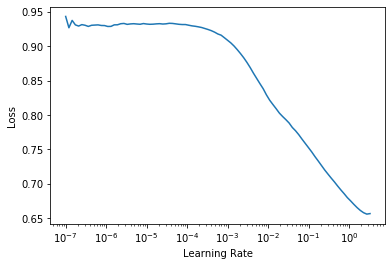

In [31]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(150, 1e-1/2)

# Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()